In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from geopy.distance import geodesic
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel, RFE

In [2]:
%pwd

'c:\\Users\\bhavy\\Desktop\\Projects\\everything-projects\\machine-learning-projects\\2-credit-card-fraud-detection\\notebooks'

In [3]:
%cd ../

c:\Users\bhavy\Desktop\Projects\everything-projects\machine-learning-projects\2-credit-card-fraud-detection


In [4]:
train_data = pd.read_csv('dataset/fraudTrain.csv')
test_data = pd.read_csv('dataset/fraudTest.csv')

In [5]:
train_data.shape

(1296675, 23)

In [6]:
test_data.shape

(555719, 23)

In [7]:
train_data.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

In [8]:
pd.set_option('display.max_columns', None)
train_data.head(1)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0


In [9]:
pd.set_option('display.max_columns', None)
test_data.head(1)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0


### Exploratory Data Analysis (EDA)
- Checking for missing values.
- Analyzing data distributions.
- Visualizing fraudulent vs. non-fraudulent transactions.
- Identifying useful features.


In [10]:
# Display basic info
print("Train Data Info:")
print(train_data.info())
print("\nTest Data Info:")
print(test_data.info())

Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  l

In [11]:
# Check for unique values
train_data.nunique()

Unnamed: 0               1296675
trans_date_trans_time    1274791
cc_num                       983
merchant                     693
category                      14
amt                        52928
first                        352
last                         481
gender                         2
street                       983
city                         894
state                         51
zip                          970
lat                          968
long                         969
city_pop                     879
job                          494
dob                          968
trans_num                1296675
unix_time                1274823
merch_lat                1247805
merch_long               1275745
is_fraud                       2
dtype: int64

In [12]:
test_data.nunique()

Unnamed: 0               555719
trans_date_trans_time    544760
cc_num                      924
merchant                    693
category                     14
amt                       37256
first                       341
last                        471
gender                        2
street                      924
city                        849
state                        50
zip                         912
lat                         910
long                        910
city_pop                    835
job                         478
dob                         910
trans_num                555719
unix_time                544760
merch_lat                546490
merch_long               551770
is_fraud                      2
dtype: int64

In [13]:
train_data.drop(['Unnamed: 0'], axis=1, inplace=True)
test_data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [14]:
train_data['is_fraud'].value_counts()

is_fraud
0    1289169
1       7506
Name: count, dtype: int64

In [15]:
# This is highly imbalanced, so we'll need techniques like SMOTE, undersampling, or weighted models.
# Resolve class imbalance using SMOTE
X = train_data.drop(columns=['is_fraud'])
y = train_data['is_fraud']

smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X.select_dtypes(include=[np.number]), y)

train_data_resampled = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled, columns=['is_fraud'])], axis=1)

print("Class balance after SMOTE:")
print(train_data_resampled['is_fraud'].value_counts())

Class balance after SMOTE:
is_fraud
0    1289169
1     644584
Name: count, dtype: int64


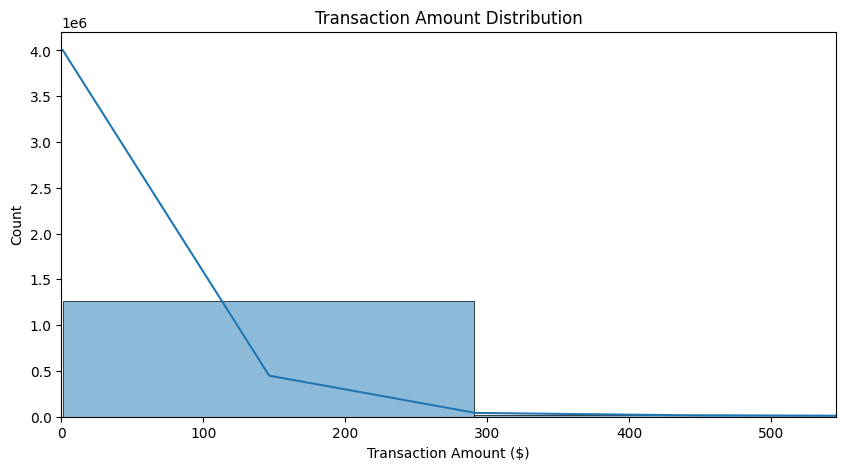

In [16]:
# Transaction amount distribution
plt.figure(figsize=(10, 5))
sns.histplot(train_data['amt'], bins=100, kde=True)
plt.title("Transaction Amount Distribution")
plt.xlabel("Transaction Amount ($)")
plt.ylabel("Count")
plt.xlim(0, train_data['amt'].quantile(0.99))
plt.show()

C:\Users\bhavy\AppData\Local\Temp\ipykernel_11796\1081314230.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_by_category.index, y=fraud_by_category.values, palette='coolwarm')


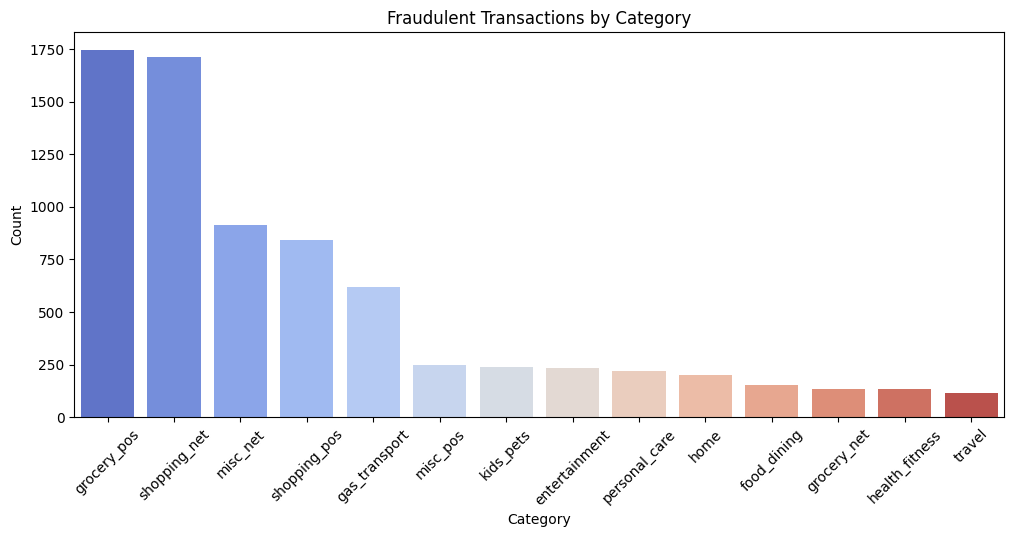

In [17]:
# Fraud by category
plt.figure(figsize=(12, 5))
fraud_by_category = train_data[train_data['is_fraud'] == 1]['category'].value_counts()
sns.barplot(x=fraud_by_category.index, y=fraud_by_category.values, palette='coolwarm')
plt.xticks(rotation=45)
plt.title("Fraudulent Transactions by Category")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

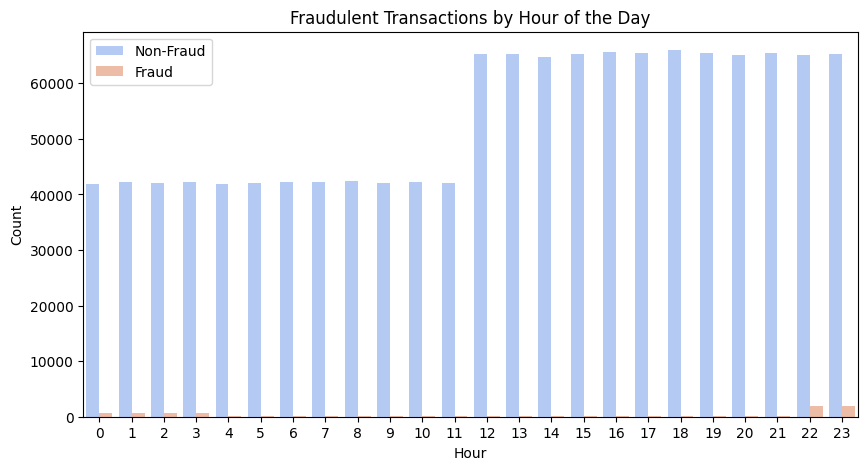

In [18]:
# Time-based fraud analysis
train_data['trans_date_trans_time'] = pd.to_datetime(train_data['trans_date_trans_time'])
train_data['hour'] = train_data['trans_date_trans_time'].dt.hour

plt.figure(figsize=(10, 5))
sns.countplot(x='hour', hue='is_fraud', data=train_data, palette='coolwarm')
plt.title("Fraudulent Transactions by Hour of the Day")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.legend(["Non-Fraud", "Fraud"])
plt.show()

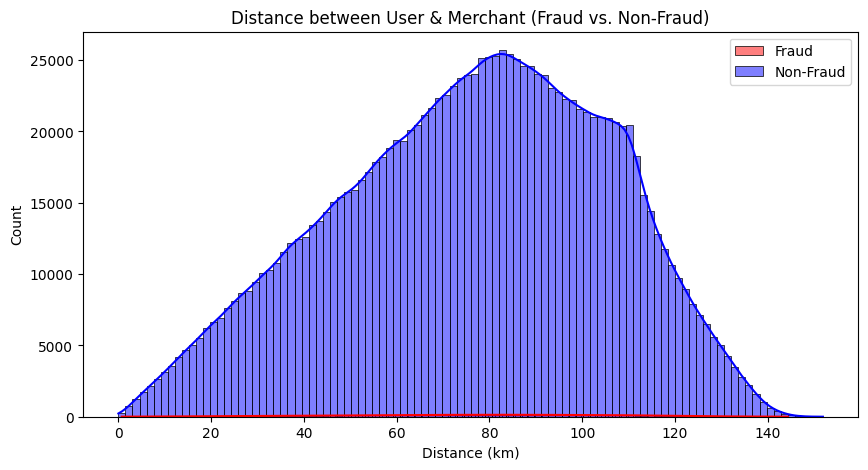

In [19]:
# we can say fraud is more likely to happen during the night hours (11pm to 4am)
# Distance feature: Customer vs. Merchant location
def calculate_distance(row):
    return geodesic((row['lat'], row['long']), (row['merch_lat'], row['merch_long'])).km

train_data['distance'] = train_data.apply(calculate_distance, axis=1)
plt.figure(figsize=(10, 5))
sns.histplot(train_data[train_data['is_fraud'] == 1]['distance'], bins=100, kde=True, color='red', label='Fraud')
sns.histplot(train_data[train_data['is_fraud'] == 0]['distance'], bins=100, kde=True, color='blue', label='Non-Fraud')
plt.title("Distance between User & Merchant (Fraud vs. Non-Fraud)")
plt.xlabel("Distance (km)")
plt.ylabel("Count")
plt.legend()
plt.show()

## Feature Engineering

In [20]:
# Convert transaction time to datetime format
train_data['trans_date_trans_time'] = pd.to_datetime(train_data['trans_date_trans_time'])
test_data['trans_date_trans_time'] = pd.to_datetime(test_data['trans_date_trans_time'])


In [21]:
# Feature Engineering
## Time-based features
train_data['hour'] = train_data['trans_date_trans_time'].dt.hour
train_data['day_of_week'] = train_data['trans_date_trans_time'].dt.dayofweek
train_data['month'] = train_data['trans_date_trans_time'].dt.month

test_data['hour'] = test_data['trans_date_trans_time'].dt.hour
test_data['day_of_week'] = test_data['trans_date_trans_time'].dt.dayofweek
test_data['month'] = test_data['trans_date_trans_time'].dt.month

In [22]:
## Distance feature: Customer vs. Merchant location
test_data['distance'] = test_data.apply(calculate_distance, axis=1)

In [23]:
## Transaction velocity: Transactions per user per hour
train_data['transactions_per_hour'] = train_data.groupby(['cc_num', 'hour'])['trans_num'].transform('count')
test_data['transactions_per_hour'] = test_data.groupby(['cc_num', 'hour'])['trans_num'].transform('count')

In [24]:
## Merchant-based fraud trends
merchant_fraud_rate = train_data.groupby('merchant')['is_fraud'].mean().to_dict()
train_data['merchant_fraud_rate'] = train_data['merchant'].map(merchant_fraud_rate)
test_data['merchant_fraud_rate'] = test_data['merchant'].map(merchant_fraud_rate)

In [25]:
## Aggregated statistics per user
train_data['user_avg_amt'] = train_data.groupby('cc_num')['amt'].transform('mean')
train_data['user_std_amt'] = train_data.groupby('cc_num')['amt'].transform('std').fillna(0)

test_data['user_avg_amt'] = test_data.groupby('cc_num')['amt'].transform('mean')
test_data['user_std_amt'] = test_data.groupby('cc_num')['amt'].transform('std').fillna(0)

In [26]:
# Convert dob to yob
train_data['dob'] = pd.to_datetime(train_data['dob'])
train_data['yob'] = train_data['dob'].dt.year

test_data['dob'] = pd.to_datetime(test_data['dob'])
test_data['yob'] = test_data['dob'].dt.year

In [27]:
pd.set_option('display.max_columns', None)
train_data.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,hour,distance,day_of_week,month,transactions_per_hour,merchant_fraud_rate,user_avg_amt,user_std_amt,yob
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0,78.773821,1,1,49,0.014207,87.393215,126.596221,1988
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,0,30.216618,1,1,75,0.010787,53.949320,118.337621,1978
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,0,108.102912,1,1,24,0.002111,65.870040,101.585754,1962
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,0,95.685115,1,1,17,0.003444,72.776673,148.593473,1967
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,0,77.702395,1,1,76,0.003769,95.178091,89.133972,1986


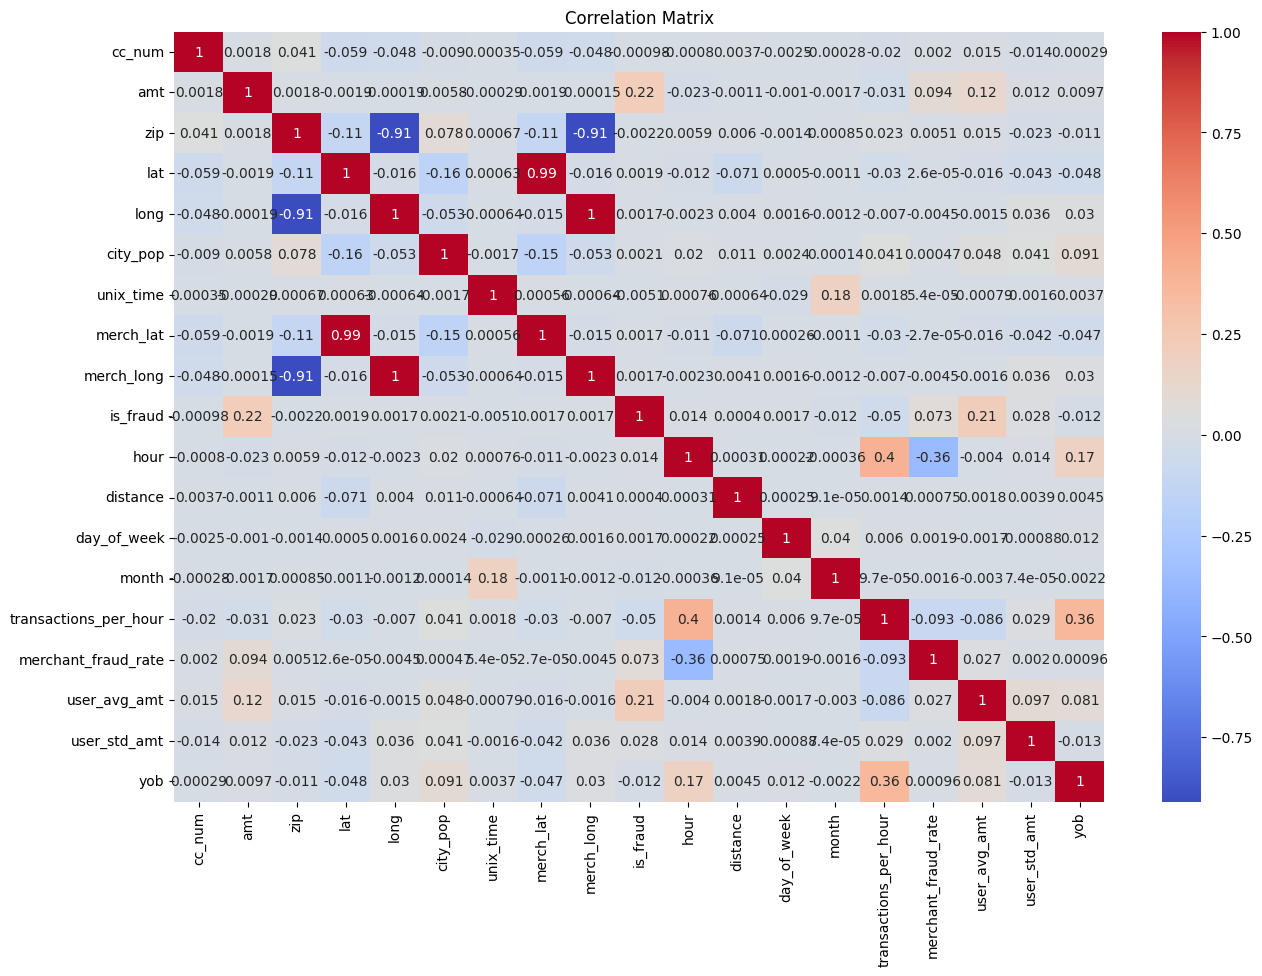

In [28]:
# Correlation matrix
numeric_features = train_data.select_dtypes(include=[np.number])
plt.figure(figsize=(15, 10))
sns.heatmap(numeric_features.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [29]:
# Drop unnecessary columns
cols_to_drop = ['trans_date_trans_time', 'cc_num', 'first', 'last', 'street', 'city', 'state', 'zip', 'lat', 'long', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'dob', 'merchant']
train_data.drop(columns=cols_to_drop, inplace=True)
test_data.drop(columns=cols_to_drop, inplace=True)

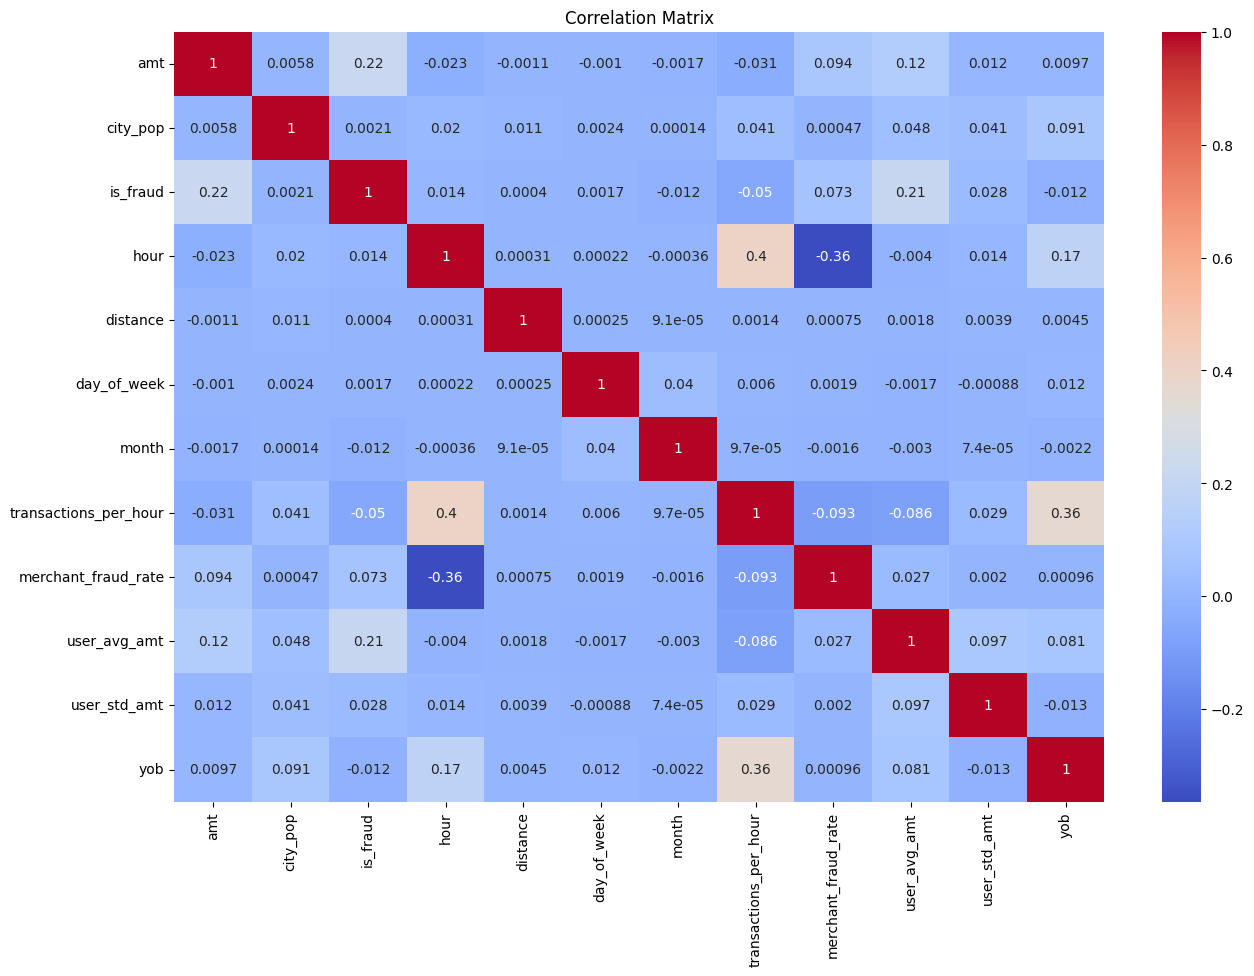

In [30]:
# Correlation matrix
numeric_features = train_data.select_dtypes(include=[np.number])
plt.figure(figsize=(15, 10))
sns.heatmap(numeric_features.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [31]:
pd.set_option('display.max_columns', None)
train_data.head()

,category,amt,gender,city_pop,job,is_fraud,hour,distance,day_of_week,month,transactions_per_hour,merchant_fraud_rate,user_avg_amt,user_std_amt,yob
0,misc_net,4.97,F,3495,"Psychologist, counselling",0,0,78.773821,1,1,49,0.014207,87.393215,126.596221,1988
1,grocery_pos,107.23,F,149,Special educational needs teacher,0,0,30.216618,1,1,75,0.010787,53.949320,118.337621,1978
2,entertainment,220.11,M,4154,Nature conservation officer,0,0,108.102912,1,1,24,0.002111,65.870040,101.585754,1962
3,gas_transport,45.00,M,1939,Patent attorney,0,0,95.685115,1,1,17,0.003444,72.776673,148.593473,1967
4,misc_pos,41.96,M,99,Dance movement psychotherapist,0,0,77.702395,1,1,76,0.003769,95.178091,89.133972,1986


In [32]:
train_data['job'].value_counts()

job
Film/video editor             9779
Exhibition designer           9199
Naval architect               8684
Surveyor, land/geomatics      8680
Materials engineer            8270
                              ... 
Veterinary surgeon               8
Information officer              8
Contracting civil engineer       7
Ship broker                      7
Warehouse manager                7
Name: count, Length: 494, dtype: int64

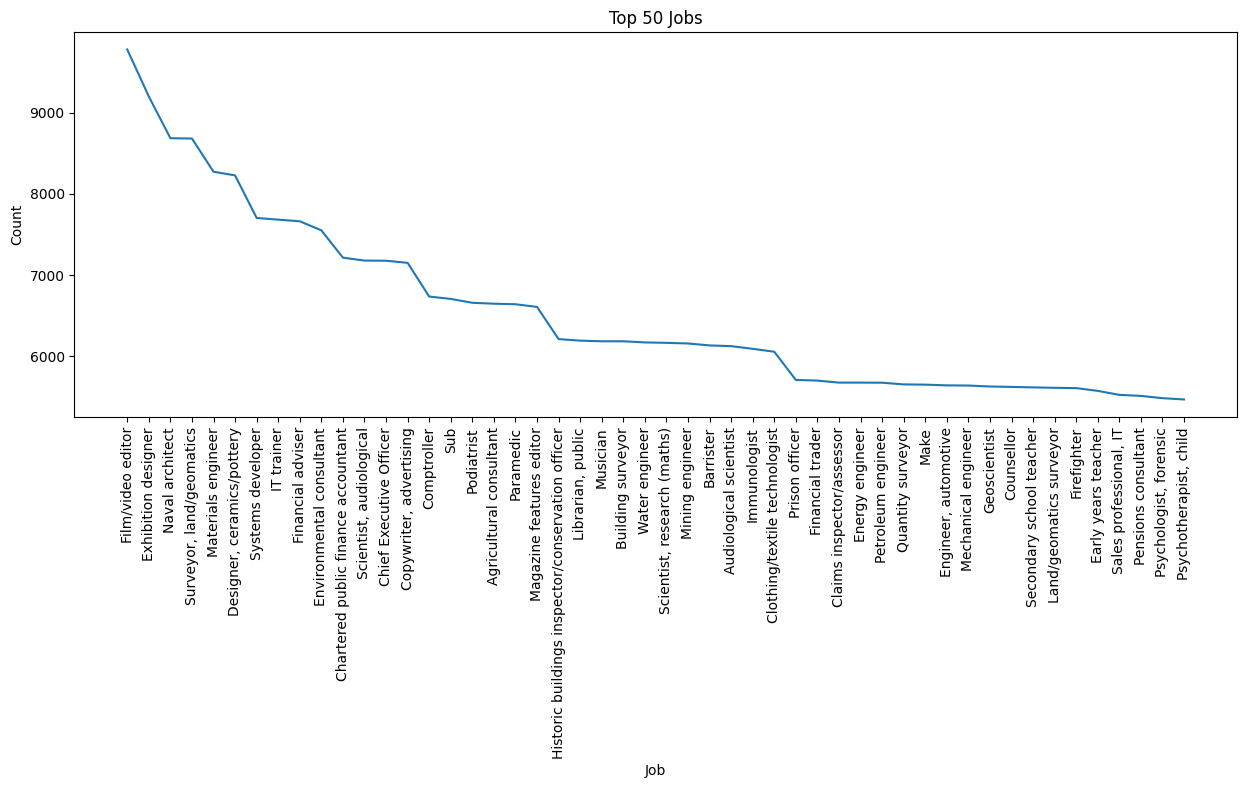

In [33]:
# Create a line plot for the top 50 jobs
plt.figure(figsize=(15, 5))
top_jobs = train_data['job'].value_counts().head(50)
sns.lineplot(x=top_jobs.index, y=top_jobs.values)
plt.xticks(rotation=90)
plt.title("Top 50 Jobs")
plt.xlabel("Job")
plt.ylabel("Count")
plt.show()

C:\Users\bhavy\AppData\Local\Temp\ipykernel_11796\3779751792.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=job_fraud_rate.index, y=job_fraud_rate.values, palette='coolwarm')


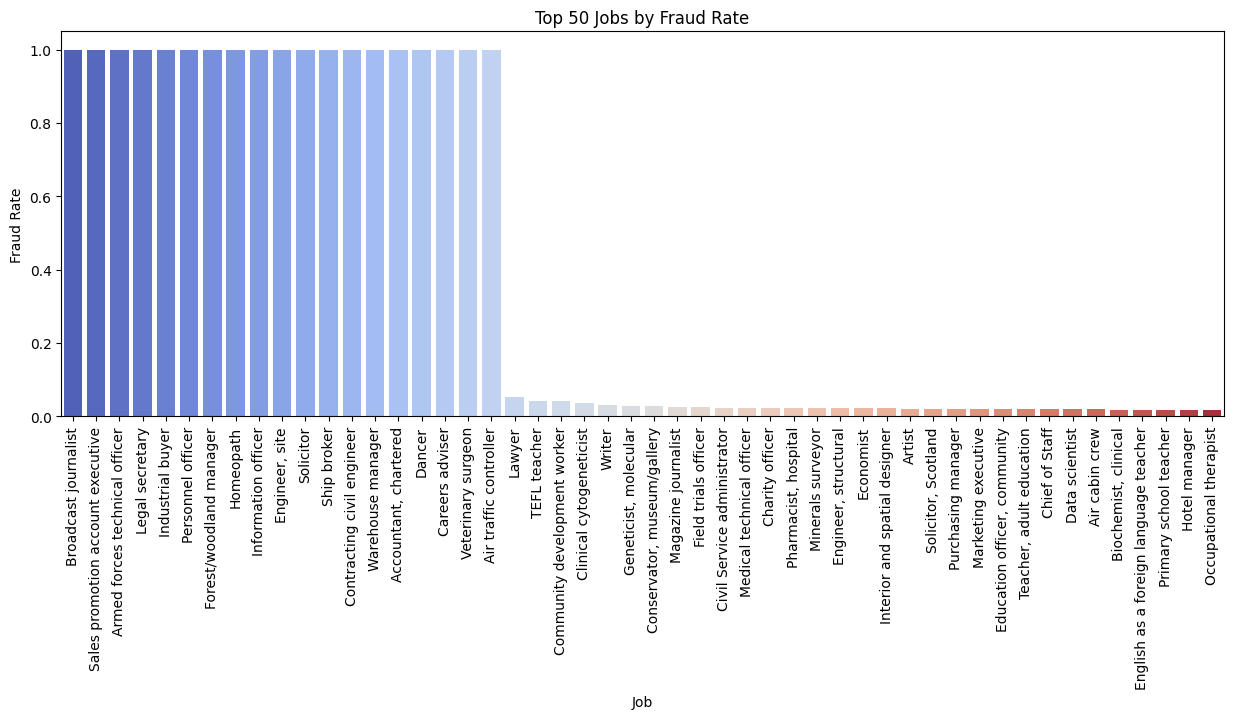

In [34]:
# Top 50 jobs by fraud rate
job_fraud_rate = train_data.groupby('job')['is_fraud'].mean().sort_values(ascending=False).head(50)
plt.figure(figsize=(15, 5))
sns.barplot(x=job_fraud_rate.index, y=job_fraud_rate.values, palette='coolwarm')
plt.xticks(rotation=90)
plt.title("Top 50 Jobs by Fraud Rate")
plt.xlabel("Job")
plt.ylabel("Fraud Rate")
plt.show()

In [35]:
print("Feature Engineering Complete!")

Feature Engineering Complete!


In [36]:
print("Train Data Shape:", train_data.shape)
print("Test Data Shape:", test_data.shape)

Train Data Shape: (1296675, 15)
Test Data Shape: (555719, 15)


In [37]:
train_data.dtypes

category                  object
amt                      float64
gender                    object
city_pop                   int64
job                       object
is_fraud                   int64
hour                       int32
distance                 float64
day_of_week                int32
month                      int32
transactions_per_hour      int64
merchant_fraud_rate      float64
user_avg_amt             float64
user_std_amt             float64
yob                        int32
dtype: object

In [38]:
from sklearn.preprocessing import OneHotEncoder

onehot_encode_cols = ['category', 'gender']
freq_encode_cols = ['job']  # Assuming high-cardinality

# Apply One-Hot Encoding on smaller categorical variables
onehot_encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
onehot_encoded = onehot_encoder.fit_transform(train_data[onehot_encode_cols])

# Convert back to DataFrame and concatenate
onehot_encoded_train_data = pd.DataFrame(onehot_encoded, columns=onehot_encoder.get_feature_names_out(onehot_encode_cols))
train_data = train_data.drop(columns=onehot_encode_cols).reset_index(drop=True)
train_data = pd.concat([train_data, onehot_encoded_train_data], axis=1)

# Apply Frequency Encoding for high-cardinality features
for col in freq_encode_cols:
    train_data[col] = train_data[col].map(train_data[col].value_counts(normalize=True))

# Now, train_data is ready for model training
print(train_data.head())


      amt  city_pop       job  is_fraud  hour    distance  day_of_week  month  \
0    4.97      3495  0.002734         0     0   78.773821            1      1   
1  107.23       149  0.003932         0     0   30.216618            1      1   
2  220.11      4154  0.000394         0     0  108.102912            1      1   
3   45.00      1939  0.001951         0     0   95.685115            1      1   
4   41.96        99  0.001556         0     0   77.702395            1      1   

   transactions_per_hour  merchant_fraud_rate  user_avg_amt  user_std_amt  \
0                     49             0.014207     87.393215    126.596221   
1                     75             0.010787     53.949320    118.337621   
2                     24             0.002111     65.870040    101.585754   
3                     17             0.003444     72.776673    148.593473   
4                     76             0.003769     95.178091     89.133972   

    yob  category_food_dining  category_gas_transp

In [39]:
train_data.rename(columns={'gender_M': 'gender'}, inplace=True)

In [40]:
# Feature Selection
X = train_data.drop(columns=['is_fraud'])
y = train_data['is_fraud']

In [41]:
train_data.nunique()

amt                          52928
city_pop                       879
job                            381
is_fraud                         2
hour                            24
distance                   1296675
day_of_week                      7
month                           12
transactions_per_hour          229
merchant_fraud_rate            650
user_avg_amt                   983
user_std_amt                   983
yob                             81
category_food_dining             2
category_gas_transport           2
category_grocery_net             2
category_grocery_pos             2
category_health_fitness          2
category_home                    2
category_kids_pets               2
category_misc_net                2
category_misc_pos                2
category_personal_care           2
category_shopping_net            2
category_shopping_pos            2
category_travel                  2
gender                           2
dtype: int64

In [42]:
# Train Data 
train_data.head()

,amt,city_pop,job,is_fraud,hour,distance,day_of_week,month,transactions_per_hour,merchant_fraud_rate,user_avg_amt,user_std_amt,yob,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender
0,4.97,3495,0.002734,0,0,78.773821,1,1,49,0.014207,87.393215,126.596221,1988,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,107.23,149,0.003932,0,0,30.216618,1,1,75,0.010787,53.949320,118.337621,1978,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,220.11,4154,0.000394,0,0,108.102912,1,1,24,0.002111,65.870040,101.585754,1962,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,45.00,1939,0.001951,0,0,95.685115,1,1,17,0.003444,72.776673,148.593473,1967,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,41.96,99,0.001556,0,0,77.702395,1,1,76,0.003769,95.178091,89.133972,1986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [43]:
set(train_data.columns) - set(test_data.columns)

{'category_food_dining',
 'category_gas_transport',
 'category_grocery_net',
 'category_grocery_pos',
 'category_health_fitness',
 'category_home',
 'category_kids_pets',
 'category_misc_net',
 'category_misc_pos',
 'category_personal_care',
 'category_shopping_net',
 'category_shopping_pos',
 'category_travel'}

In [44]:
# test data is only behind by one step of one hot encoding

In [45]:
train_data.to_csv('dataset/cleaned_train_data.csv', index=False)

In [46]:
test_data.rename(columns={'gender_M': 'gender'}, inplace=True)

In [47]:
from sklearn.preprocessing import OneHotEncoder

onehot_encode_cols = ['category', 'gender']
freq_encode_cols = ['job']  # Assuming high-cardinality

# Apply One-Hot Encoding on smaller categorical variables
onehot_encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
onehot_encoder.fit(test_data[onehot_encode_cols])
onehot_encoded = onehot_encoder.fit_transform(test_data[onehot_encode_cols])

# Convert back to DataFrame and concatenate
onehot_encoded_test_data = pd.DataFrame(onehot_encoded, columns=onehot_encoder.get_feature_names_out(onehot_encode_cols))
test_data = test_data.drop(columns=onehot_encode_cols).reset_index(drop=True)
test_data = pd.concat([test_data, onehot_encoded_test_data], axis=1)

# Apply Frequency Encoding for high-cardinality features
for col in freq_encode_cols:
    test_data[col] = test_data[col].map(test_data[col].value_counts(normalize=True))

In [48]:
# Now, test_data is ready for model training
test_data.head()

,amt,city_pop,job,is_fraud,hour,day_of_week,month,distance,transactions_per_hour,merchant_fraud_rate,user_avg_amt,user_std_amt,yob,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M
0,2.86,333497,0.004373,0,12,6,6,24.613746,26,0.001101,61.893062,158.690646,1968,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,29.84,302,0.004562,0,12,6,6,104.834043,62,0.002740,53.596523,102.395948,1990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,41.28,34496,0.004655,0,12,6,6,59.204796,73,0.001166,83.053812,103.740968,1970,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,60.05,54767,0.001193,0,12,6,6,27.615117,41,0.004297,59.207526,108.530732,1987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,3.19,1126,0.001603,0,12,6,6,104.423175,28,0.001203,55.274501,76.159193,1955,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [49]:
test_data.to_csv('dataset/cleaned_test_data.csv', index=False)

In [50]:
# Save model one hot encoder and frequency encoder
import joblib
joblib.dump(onehot_encoder, 'artifacts/onehot_encoder.joblib')

['artifacts/onehot_encoder.joblib']

In [51]:
train_data.columns

Index(['amt', 'city_pop', 'job', 'is_fraud', 'hour', 'distance', 'day_of_week',
       'month', 'transactions_per_hour', 'merchant_fraud_rate', 'user_avg_amt',
       'user_std_amt', 'yob', 'category_food_dining', 'category_gas_transport',
       'category_grocery_net', 'category_grocery_pos',
       'category_health_fitness', 'category_home', 'category_kids_pets',
       'category_misc_net', 'category_misc_pos', 'category_personal_care',
       'category_shopping_net', 'category_shopping_pos', 'category_travel',
       'gender'],
      dtype='object')